In [6]:
!pip install -q transformers datasets scikit-learn pandas
!pip install numpy==1.26.4

In [7]:
import pandas as pd

# Replace 'your_dataset.csv' with the actual uploaded file name
df = pd.read_csv("/content/sample_data/text-classification/data/IMDB Dataset.csv")
# Select the correct columns and rename them
df = df[["review", "sentiment"]]
df = df.rename(columns={"review": "text", "sentiment": "label"})
# Map the sentiment values to integers
df["label"] = df["label"].map({"positive": 1, "negative": 0})
df.head()

,text,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [8]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(df["text"], df["label"], test_size=0.2, stratify=df["label"])

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(pd.DataFrame({"text": train_texts, "label": train_labels}))
val_dataset = Dataset.from_pandas(pd.DataFrame({"text": val_texts, "label": val_labels}))


In [9]:
from transformers import DistilBertTokenizerFast

# Load the tokenizer (from Drive if offline)
tokenizer = DistilBertTokenizerFast.from_pretrained("/content/drive/MyDrive/models/distilbert-base-uncased")

# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

# Apply tokenization
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)


Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
# Rename 'label' to 'labels'
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")

# Set format to PyTorch tensors
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


In [11]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/models/distilbert-base-uncased",
    num_labels=2  # Binary classification: 0 = negative, 1 = positive
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/models/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")


('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/vocab.txt',
 'saved_model/added_tokens.json',
 'saved_model/tokenizer.json')

In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [15]:
import os
os.environ["WANDB_DISABLED"] = "true"  # Prevent wandb prompt

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none",  # disable wandb
)

In [16]:
!pip install --upgrade transformers

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


In [18]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.313600,0.250287,0.905500,0.906017,0.906468,0.905567
2,0.166300,0.369980,0.891500,0.885124,0.946772,0.831014
3,0.085800,0.357809,0.913500,0.914059,0.913605,0.914513


TrainOutput(global_step=1500, training_loss=0.18856358337402343, metrics={'train_runtime': 1174.9108, 'train_samples_per_second': 20.425, 'train_steps_per_second': 1.277, 'total_flos': 3178820165548032.0, 'train_loss': 0.18856358337402343, 'epoch': 3.0})

In [19]:
results = trainer.evaluate()
print("Validation Metrics:", results)

Validation Metrics: {'eval_loss': 0.25028711557388306, 'eval_accuracy': 0.9055, 'eval_f1': 0.9060169070114371, 'eval_precision': 0.9064676616915422, 'eval_recall': 0.9055666003976143, 'eval_runtime': 28.7231, 'eval_samples_per_second': 69.63, 'eval_steps_per_second': 4.352, 'epoch': 3.0}


In [20]:
import json

with open("/content/drive/MyDrive/text-classification-results.json", "w") as f:
    json.dump(results, f, indent=4)


In [21]:
import logging
logging.basicConfig(level=logging.INFO)


In [22]:
from transformers import pipeline

# Load the classifier
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Predict new texts
classifier(["This movie was amazing!", "Worst film ever."])


Device set to use cuda:0


[{'label': 'LABEL_1', 'score': 0.9881706237792969},
 {'label': 'LABEL_0', 'score': 0.9758895635604858}]

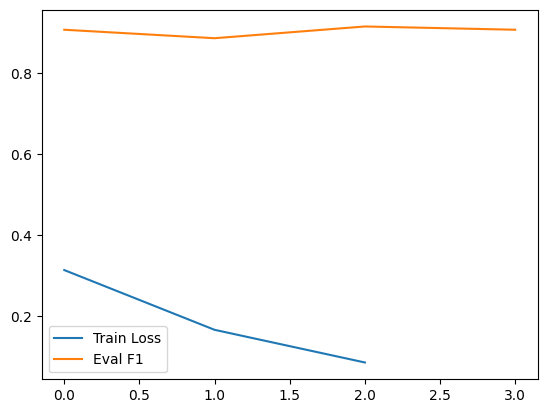

In [23]:
import matplotlib.pyplot as plt
logs = trainer.state.log_history

train_loss = [log['loss'] for log in logs if 'loss' in log]
eval_f1 = [log['eval_f1'] for log in logs if 'eval_f1' in log]

plt.plot(train_loss, label="Train Loss")
plt.plot(eval_f1, label="Eval F1")
plt.legend()
plt.show()
